In [1]:
from home_cage_prediction.load import load_freeze_session_data, load_home_cage_data

import numpy as np
from scipy import stats

from sklearn.preprocessing import quantile_transform, power_transform
from sklearn.model_selection import (
    cross_val_score,
    LeaveOneOut,
)
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
DATA_DIR = Path(os.environ["DATA_DIR"]) / "raw"

HOME_CAGE_SEGMENT = "pre-cond"
FREEZE_SESSION = "cond"

In [3]:
df_hc = (
    load_home_cage_data(data_dir=DATA_DIR, segment=HOME_CAGE_SEGMENT)
    .set_index("mouse_name")
    .rename(columns={"eatpaw": "eathand"})
)


df_fr = load_freeze_session_data(data_dir=DATA_DIR, session=FREEZE_SESSION).set_index(
    "mouse_name"
)

display(df_hc.head(3))
display(df_fr.head(3))


FREEZE_COL = "cond_t1"

df = df_hc.join(df_fr[FREEZE_COL], how="inner")
display(df.head(3))

,drink,eat,groom,hang,sniff,rear,rest,walk,eathand,agg_explore,agg_cons,agg_low
mouse_name,,,,,,,,,,,,
F1,0.000905,0.074037,0.055741,0.053475,0.217713,0.006973,0.552253,0.019494,0.019410,0.079941,0.150092,0.769966
F2,0.001171,0.099765,0.065576,0.047145,0.224245,0.008726,0.519748,0.014983,0.018642,0.070854,0.185154,0.743992
F3,0.000623,0.161955,0.082278,0.060919,0.161275,0.007427,0.496778,0.015108,0.013638,0.083454,0.258493,0.658053


,cond_base,cond_t1,cond_t3
mouse_name,,,
F1,0.000000,0.000000,83.333333
F2,0.000000,16.666667,100.000000
F3,5.555556,16.666667,50.000000


,drink,eat,groom,hang,sniff,rear,rest,walk,eathand,agg_explore,agg_cons,agg_low,cond_t1
mouse_name,,,,,,,,,,,,,
F1,0.000905,0.074037,0.055741,0.053475,0.217713,0.006973,0.552253,0.019494,0.019410,0.079941,0.150092,0.769966,0.000000
F2,0.001171,0.099765,0.065576,0.047145,0.224245,0.008726,0.519748,0.014983,0.018642,0.070854,0.185154,0.743992,16.666667
F3,0.000623,0.161955,0.082278,0.060919,0.161275,0.007427,0.496778,0.015108,0.013638,0.083454,0.258493,0.658053,16.666667


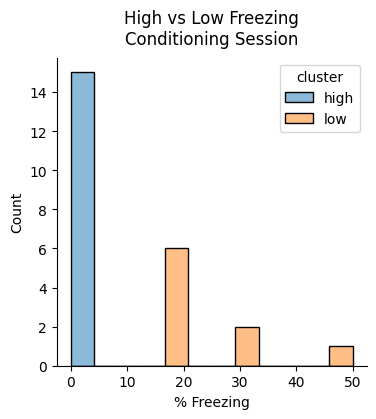

In [6]:
df["cluster"] = np.where(df[FREEZE_COL] <= df[FREEZE_COL].median(), "high", "low")

f, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.histplot(data=df, x=FREEZE_COL, hue="cluster", ax=ax, bins=12)
ax.set_xlabel("% Freezing")
ax.set_title("High vs Low Freezing\nConditioning Session", pad=10)
sns.despine(fig=f)

In [7]:
FREEZE_COLS = [FREEZE_COL, "cluster"]


pipe = Pipeline(
    [
        ("norm", StandardScaler()),
        ("regressor", LinearDiscriminantAnalysis(n_components=1)),
    ]
)

cv = LeaveOneOut()

X = df[[c for c in df.columns if c not in FREEZE_COLS]]
y = df["cluster"]

scores = []
models = []
for i, (train, test) in enumerate(cv.split(X, y)):
    pipe_i = clone(pipe)
    pipe_i.fit(X.iloc[train], y.iloc[train])
    y_pred = pipe_i.predict(X.iloc[test])
    score_i = f1_score(y.iloc[test], y_pred, average="macro")
    models.append(pipe_i)
    scores.append(score_i)

scores = np.asarray(scores)
models = models

best_model = models[np.argmax(scores)]
mean_score_obs = scores.mean()
print(f"Mean F1 Score: {mean_score_obs:.2f}")

Mean F1 Score: 0.75


In [14]:
Y_COL = FREEZE_COL

pipe = Pipeline(
    [
        ("norm", StandardScaler()),
        ("regressor", LinearDiscriminantAnalysis()),
    ]
)

cv = LeaveOneOut()

X = df[[c for c in df.columns if c not in FREEZE_COLS]]
y = df["cluster"]

scores = []
n_boot = 400
for i in range(n_boot):
    y_boot_i = np.random.permutation(y)
    scores_i = cross_val_score(pipe, X, y_boot_i, cv=cv, scoring="f1_macro")
    scores.append(scores_i.mean())

scores = np.array(scores)
thresh = np.percentile(scores, 95)
p_val = (scores >= mean_score_obs).mean()
print(f"p-value: {p_val:.3f}, (obs: {mean_score_obs:2f} thresh: {thresh:.2f})")

p-value: 0.045, (obs: 0.750000 thresh: 0.71)


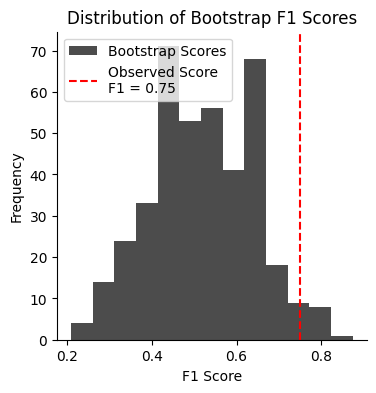

In [15]:
f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.hist(scores, bins=13, alpha=0.7, label="Bootstrap Scores", color="black")

ax.axvline(
    x=mean_score_obs,
    color="r",
    linestyle="--",
    label=f"Observed Score\nF1 = {mean_score_obs:.2f}",
)

ax.set_xlabel("F1 Score")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Bootstrap F1 Scores")
ax.legend()

sns.despine(fig=f)

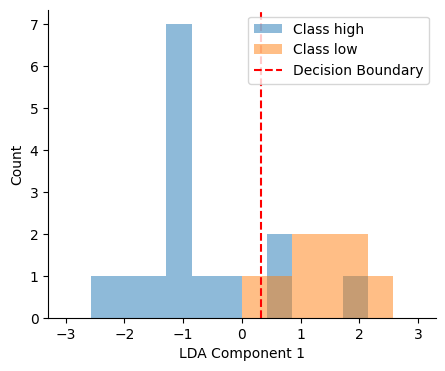

In [16]:
fig, ax = plt.subplots(figsize=(5, 4))

X_transformed = best_model.transform(X)

bins = np.linspace(-3, 3, 15)

for class_value in np.unique(y):
    ax.hist(
        X_transformed[y == class_value],
        bins=bins,
        alpha=0.5,
        label=f"Class {class_value}",
    )


means = [X_transformed[y == class_value].mean() for class_value in np.unique(y)]
decision_boundary = np.mean(means)
ax.axvline(x=decision_boundary, color="red", linestyle="--", label="Decision Boundary")

ax.set_xlabel("LDA Component 1")
ax.set_ylabel("Count" if isinstance(ax, plt.Axes) else "Density")
ax.legend()

sns.despine(fig=fig)